In [1]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Subset
import pandas as pd
import numpy as np

torch.cuda.set_device(0)
device = torch.device("cuda")

In [22]:
from torch.utils.data import Dataset
from PIL import Image
import os

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.JPEG'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path  # Return the image and its path (no labels)

In [23]:
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
trainset = ImageFolder("data/train/", transform=train_transform)
validset = ImageFolder("data/train/", transform=transform)
testset = TestDataset(root_dir="data/test_all/", transform=transform)

train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size
train_indices, valid_indices = random_split(range(len(trainset)), [train_size, valid_size], generator=torch.Generator().manual_seed(42))
train_subset = Subset(trainset, train_indices)
valid_subset = Subset(validset, valid_indices)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

In [ ]:
from collections import Counter

# Count elements in the training set
train_labels = [trainset.targets[idx] for idx in train_indices]
train_class_counts = Counter(train_labels)
print("Training set class counts:")
for class_idx, count in train_class_counts.items():
    print(f"Class {class_idx}: {count}")

# Count elements in the validation set
valid_labels = [trainset.targets[idx] for idx in valid_indices]
valid_class_counts = Counter(valid_labels)
print("\nValidation set class counts:")
for class_idx, count in valid_class_counts.items():
    print(f"Class {class_idx}: {count}")

Training set class counts:
Class 34: 1433
Class 0: 1445
Class 12: 1438
Class 49: 1442
Class 8: 1457
Class 18: 1447
Class 36: 1417
Class 40: 1434
Class 23: 1410
Class 21: 1420
Class 44: 1440
Class 43: 1460
Class 47: 1417
Class 15: 1432
Class 22: 1437
Class 38: 1439
Class 28: 1461
Class 35: 1480
Class 11: 1427
Class 46: 1412
Class 26: 1467
Class 4: 1440
Class 9: 1424
Class 48: 1431
Class 27: 1453
Class 10: 866
Class 30: 1445
Class 45: 1446
Class 20: 1444
Class 32: 1444
Class 31: 1421
Class 14: 1438
Class 25: 1411
Class 42: 1437
Class 24: 1458
Class 16: 1460
Class 33: 1431
Class 17: 1438
Class 29: 1458
Class 39: 1447
Class 2: 1445
Class 41: 1464
Class 5: 1434
Class 6: 1443
Class 3: 1449
Class 7: 1455
Class 1: 1425
Class 37: 1441
Class 19: 1444
Class 13: 401

Validation set class counts:
Class 8: 343
Class 24: 342
Class 12: 362
Class 48: 369
Class 11: 373
Class 16: 340
Class 45: 354
Class 7: 345
Class 38: 361
Class 39: 353
Class 27: 347
Class 10: 242
Class 15: 368
Class 26: 333
Class 25: 3

Training Dataset:


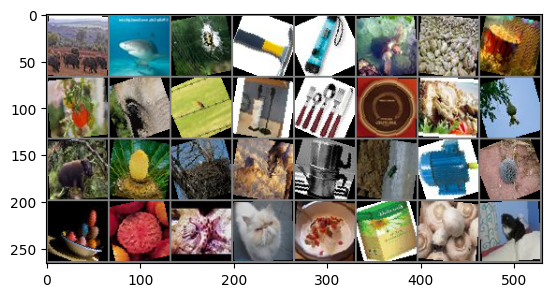

Labels: tensor([43, 21, 40, 26,  3, 48,  4, 15, 45, 20,  8, 46, 41, 25, 34, 32, 43, 33,
        32, 43, 35,  5, 31, 32, 19, 45, 18, 14, 27, 44, 24, 14])
Validation Dataset:


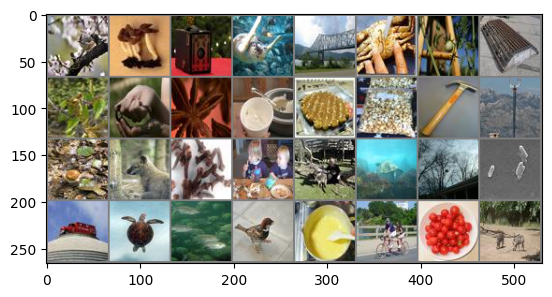

Labels: tensor([ 8, 24, 12, 48, 11, 16, 45, 11,  7, 38, 39, 27, 10, 15, 26, 25, 24, 28,
        39, 16, 28, 48, 25,  2, 47, 48, 21,  8, 27,  6, 45, 43])


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Visualize one batch from the training dataset
print("Training Dataset:")
train_images, train_labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(train_images))
print("Labels:", train_labels)

# Visualize one batch from the validation dataset
print("Validation Dataset:")
valid_images, valid_labels = next(iter(validloader))
imshow(torchvision.utils.make_grid(valid_images))
print("Labels:", valid_labels)

In [6]:
class Net(nn.Module): # W prawdziwej implementacji należy znacznie zwiększyć rozmiar sieci
    def __init__(self):
        super().__init__()
        ## Warstwa konwolucyjna
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0) # out_channels to liczba filtrów, in_chanels to liczba wchodzących cech
        ## Warstwa max pooling 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 13 * 13, 120) # 16 * 5 * 5 to rozmiar wektora po spłaszczeniu przetworzonego obrazu
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 50)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=50, bias=True)
)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [8]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/5] loss: %.3f' %
          (epoch+1 ,  running_loss / 2000))
    running_loss = 0.0

print('Finished Training')

[1/5] loss: 3.528
[2/5] loss: 3.086
[3/5] loss: 2.910
[4/5] loss: 2.807
[5/5] loss: 2.744
[6/5] loss: 2.693
[7/5] loss: 2.655
[8/5] loss: 2.630
[9/5] loss: 2.592
[10/5] loss: 2.580
Finished Training


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

all_labels = []
all_predictions = []

with torch.no_grad():
    for data in validloader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

accuracy = accuracy_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions)

Accuracy: 0.3489


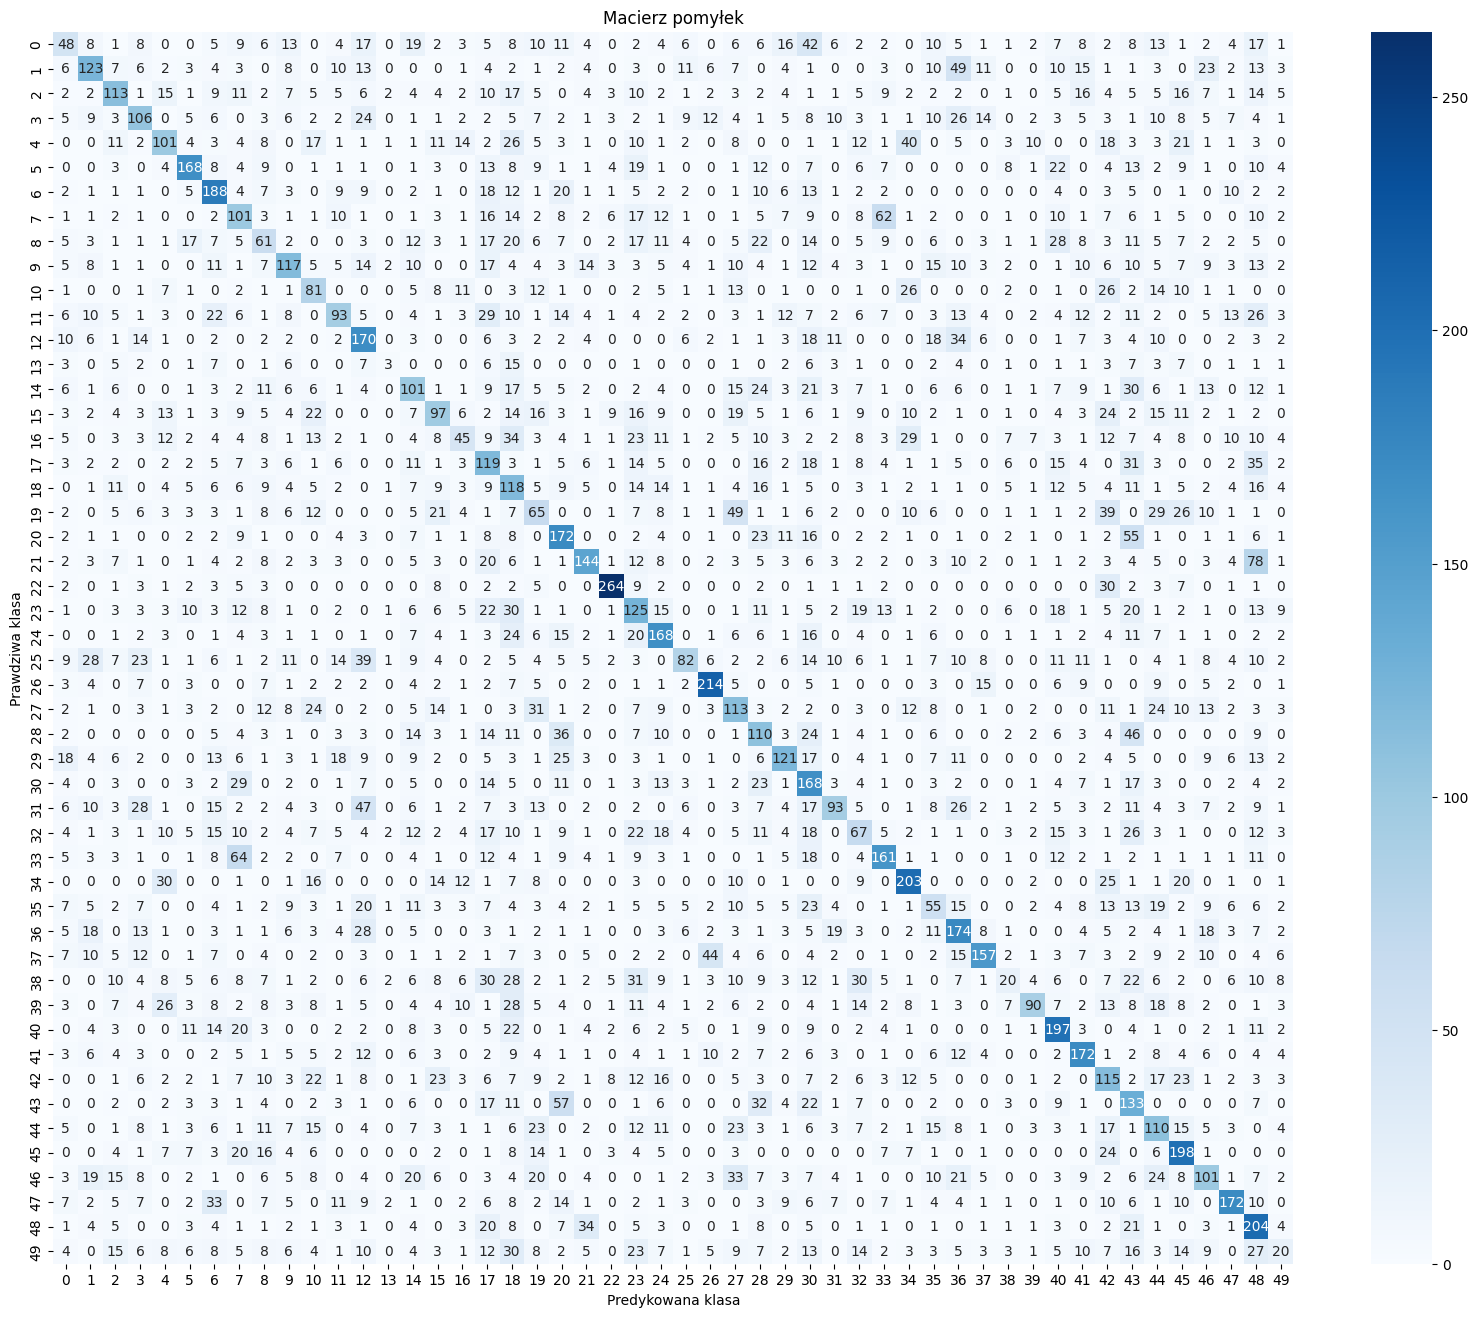

              precision    recall  f1-score   support

           0       0.22      0.14      0.17       355
           1       0.41      0.33      0.36       375
           2       0.37      0.32      0.34       355
           3       0.34      0.30      0.32       351
           4       0.37      0.28      0.32       360
           5       0.56      0.46      0.51       366
           6       0.39      0.53      0.45       357
           7       0.25      0.29      0.27       345
           8       0.20      0.18      0.19       343
           9       0.39      0.31      0.35       376
          10       0.26      0.33      0.29       242
          11       0.39      0.25      0.30       373
          12       0.34      0.47      0.39       362
          13       0.17      0.03      0.05       102
          14       0.27      0.28      0.27       362
          15       0.33      0.26      0.29       368
          16       0.28      0.13      0.18       340
          17       0.22    

In [13]:
accuracy = accuracy_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions)

# Wyświetlenie accuracy
print(f'Accuracy: {accuracy:.4f}')

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()

print(classification_rep)

In [34]:
test_mapping = pd.DataFrame()
for data in testloader:
    images, paths = data
    images = images.to(device)
    outputs = net(images).cpu()
    for i in range(len(paths)):
        path = paths[i]
        cl = torch.argmax(outputs[i]).item()
        img_name = path.split("/")[-1]
        new_row = pd.DataFrame({"img": [img_name], "cl": [cl]})
        test_mapping = pd.concat([test_mapping, new_row], ignore_index=True)

test_mapping.to_csv("pred.csv",index=False, header=False)